# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: GED vs. factor analysis
#### Instructor: sincxpress.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [3]:
## preliminary 

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files//emptyEEG')
lf = matfile['lf'][0,0]
EEG = matfile['EEG'][0,0]

EEG['srate']  = 500
EEG['trials'] = 200
EEG['pnts']   = 1000
EEG['times']  = np.arange(0,EEG['pnts'])/EEG['srate']
EEG['data']   = np.zeros( (int(EEG['nbchan']),int(EEG['pnts']),int(EEG['trials'])) )

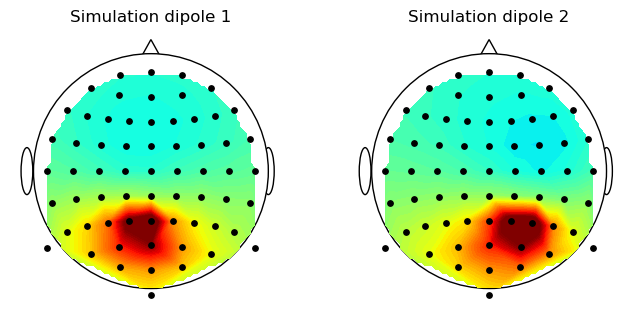

In [4]:
## dipole locations

dipoleLoc1 = 108
dipoleLoc2 = 134

_,axs = plt.subplots(1,2,figsize=(8,5))
topoplotIndie(-lf['Gain'][:,0,dipoleLoc1], EEG['chanlocs'], 'Simulation dipole 1', axs[0])
topoplotIndie(-lf['Gain'][:,0,dipoleLoc2], EEG['chanlocs'], 'Simulation dipole 2', axs[1])

In [5]:
## insert activity waveforms into dipole data

# frequencies of the two dipoles
freq1 = 12
freq2 = 12

# time point of "stimulus" onset
tidx = np.argmin( np.abs(EEG['times']-np.mean(EEG['times'])) )

# the "innards" of the sine function
omega1 = 2*np.pi*freq1*EEG['times'][tidx:]
omega2 = 2*np.pi*freq2*EEG['times'][tidx:]

lfsize = np.shape(lf['Gain'])

# loop over trials
for ti in range(EEG['trials']):
    
    # source waveforms (sine waves with random phase)
    swave1 = 2*np.sin( omega1 + np.random.rand(1)*2*np.pi )
    swave2 = 2*np.sin( omega2 + np.random.rand(1)*2*np.pi )
    
    dipole_data = np.random.randn(lfsize[2],EEG['pnts'])/4
    dipole_data[dipoleLoc1,tidx:] += swave1
    dipole_data[dipoleLoc2,tidx:] += swave2
    
    # project to scalp
    EEG['data'][:,:,ti] = lf['Gain'][:,0,:]@dipole_data


In [6]:
## GED for spatial filter

covPre = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )
covPst = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )


# covariance matrices per trial
for ti in range(int(EEG['trials'])):
    
    # "prestim" covariance
    covPre += np.cov(EEG['data'][:,:tidx,ti])
    
    # "post-stim" covariance
    covPst += np.cov(EEG['data'][:,tidx:,ti])
    

covPre = covPre/ti
covPst = covPst/ti

# GED
evals,evecs = scipy.linalg.eigh(covPst,covPre)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]


#### compute filter forward models and flip sign

# component 1:
map1 = evecs[:,0].T@covPst # get component
idx  = np.argmax(np.abs(map1)) # find max magnitude
map1 = map1*np.sign(map1[idx])  # possible sign flip

# component 2:
map2 = evecs[:,1].T@covPst # get component
idx  = np.argmax(np.abs(map2)) # find max magnitude
map2 = map2*np.sign(map2[idx]) # possible sign flip


### compute component time series (projections)
cdat = np.zeros( (2,int(EEG['pnts']),int(EEG['trials'])) )
for triali in range(int(EEG['trials'])):
    cdat[:,:,triali] = evecs[:,:2].T@EEG['data'][:,:,triali]


# for later, it will be convenient to have component time series data as 2D
comp2d = np.reshape(cdat,(2,int(np.prod(cdat.shape)/2)),order='F')

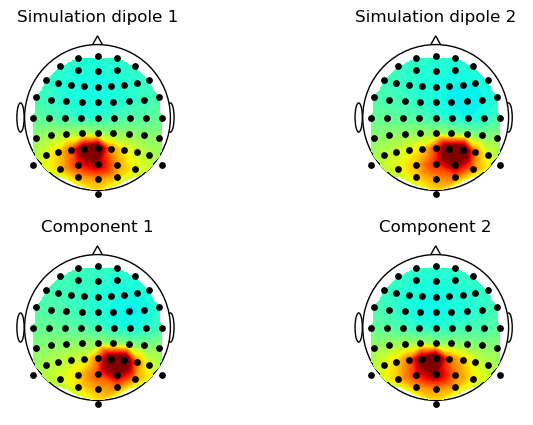

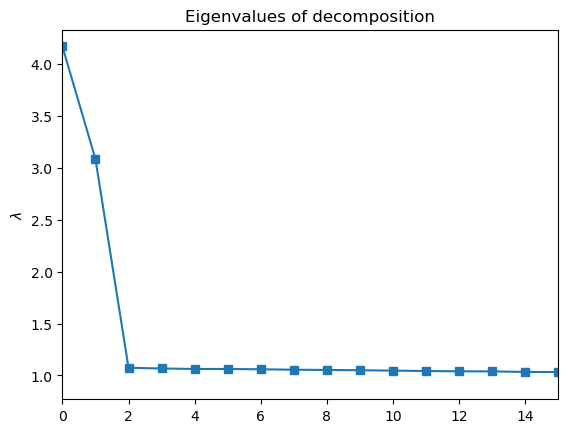

In [7]:
# show the results 


_,axs = plt.subplots(2,2,figsize=(8,5))

topoplotIndie(-lf['Gain'][:,0,dipoleLoc1], EEG['chanlocs'], 'Simulation dipole 1', axs[0,0])
topoplotIndie(-lf['Gain'][:,0,dipoleLoc2], EEG['chanlocs'], 'Simulation dipole 2', axs[0,1])
topoplotIndie(map1,EEG['chanlocs'],'Component 1',axs[1,0])
topoplotIndie(map2,EEG['chanlocs'],'Component 2',axs[1,1])
plt.show()

plt.plot(evals,'s-')
plt.xlim([0,15])
plt.ylabel('$\lambda$')
plt.title('Eigenvalues of decomposition')
plt.show()


In [8]:
## factor analysis
from sklearn.decomposition import FactorAnalysis

# fit the factor analysis
data2d = np.reshape( EEG['data'],(EEG['nbchan'][0][0],-1),order='F' ).T
FA = FactorAnalysis(n_components=2)

# reconstructed time series (leave as 2D matrix)
F = FA.fit_transform(data2d).T

# component weights
Lambda = FA.components_

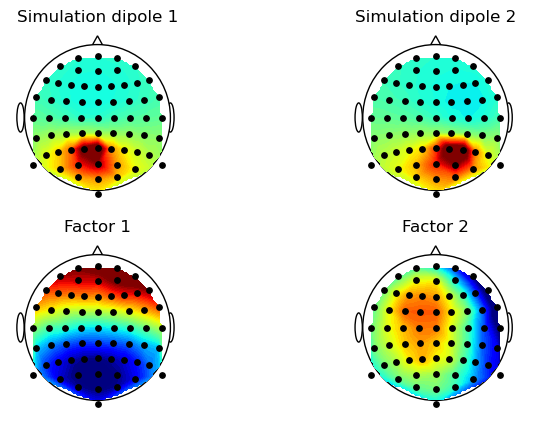

In [9]:
# show the topomaps

_,axs = plt.subplots(2,2,figsize=(8,5))

topoplotIndie(-lf['Gain'][:,0,dipoleLoc1], EEG['chanlocs'], 'Simulation dipole 1', axs[0,0])
topoplotIndie(-lf['Gain'][:,0,dipoleLoc2], EEG['chanlocs'], 'Simulation dipole 2', axs[0,1])
topoplotIndie(Lambda[0,:],EEG['chanlocs'],'Factor 1',axs[1,0])
topoplotIndie(Lambda[1,:],EEG['chanlocs'],'Factor 2',axs[1,1])
plt.show()

In [10]:
## standard TF analysis on components

# frequencies in Hz
frex = np.linspace(2,20,20)

# initialize time-frequency matrix
ctf = np.zeros( (2,len(frex),EEG['pnts']) ) # component TF
ftf = np.zeros( (2,len(frex),EEG['pnts']) ) # factor TF


# loop over frequencies
for fi in range(len(frex)):

    # GED components
    fdat = filterFGx(comp2d,EEG['srate'],frex[fi],4)[0]
    Gpow = np.abs( scipy.signal.hilbert(fdat) )**2
    Gpow = np.reshape(Gpow,[2,EEG['pnts'],EEG['trials']],order='F')
    ctf[:,fi,:] = np.mean( Gpow ,axis=2)
    
    # FA components
    fdat = filterFGx(F,EEG['srate'],frex[fi],4)[0]
    Fpow = np.abs( scipy.signal.hilbert(fdat) )**2
    Fpow = np.reshape(Fpow,[2,EEG['pnts'],EEG['trials']],order='F')
    ftf[:,fi,:] = np.mean( Fpow ,axis=2)
        

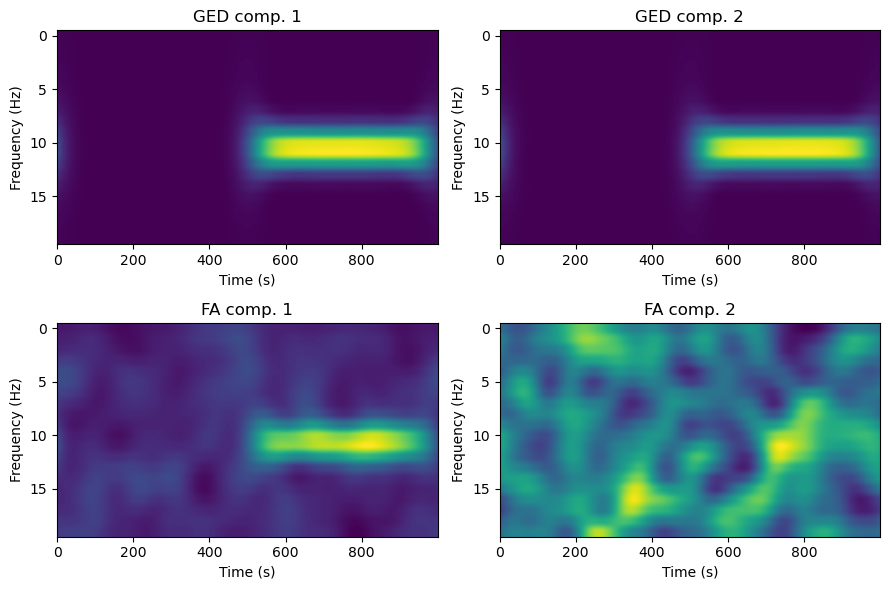

In [11]:
## Show the time-frequency power maps

_,axs = plt.subplots(2,2,figsize=(9,6))

for compi in range(2):
    
    # GED component
    axs[0,compi].imshow(ctf[compi,:,:],aspect='auto')
    axs[0,compi].set_title(f'GED comp. {compi+1}')
    axs[0,compi].set_xlabel('Time (s)')
    axs[0,compi].set_ylabel('Frequency (Hz)')
    
    # factor analysis component
    axs[1,compi].imshow(ftf[compi,:,:],aspect='auto')
    axs[1,compi].set_title(f'FA comp. {compi+1}')
    axs[1,compi].set_xlabel('Time (s)')
    axs[1,compi].set_ylabel('Frequency (Hz)')
    

plt.tight_layout()
plt.show()